# Import Necessary Libraries

In [27]:
# Import libraries for basic calculations and plotting

import os 
import pandas as pd
import numpy as np
from os import listdir, rename
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Import Keras and Tensorflow
# Won't be called directly but are frameworks MRCNN is built on

import tensorflow as tf
import tensorflow.contrib.keras as keras
from keras import applications

/Users/joshblumer/opt/anaconda3/envs/mask-env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/joshblumer/opt/anaconda3/envs/mask-env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/joshblumer/opt/anaconda3/envs/mask-env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/joshbl

In [3]:
# Import all necessary MRCNN libraries and functions

from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt

# Import Data

In [78]:
pwd

'/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template'

### Define image and annotation file paths and rename files by removing their string prefix in order to be processed as integers. Commands are commented out to preserve paths.

In [ ]:
# !!!Do not execute this cell more than once!!!

#path = '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/images'
#files = os.listdir(path)

#for index, file in enumerate(files):
   #if file.startswith("Cars"):
       #os.rename(os.path.join(path, file), os.path.join(path, file[4:]))

#path = '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/annotations'
#files = os.listdir(path)

#for index, file in enumerate(files):
   #if file.startswith("Cars"):
       #os.rename(os.path.join(path, file), os.path.join(path, file[4:]))

# Data Preprocessing and Configuration

### Develop the dataset object required by mrcnn library to manage train, validate, and test sets.

In [85]:
# Define a class and functions that load the image & annotation data, extract the bounding box information from the 
# annotation files, generate the masks with the bounding box coordinates, and return the path to each image

class LicenseDataset(Dataset):
    
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class and file locations
        self.add_class("dataset", 1, "license_plate")
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        # iterate through images and extract their id
        for filename in listdir(images_dir):
            image_id = filename[:-4]
            # set thresholds for train and test sets
            if is_train and int(image_id) >= 365:
                continue
            if not is_train and int(image_id) < 365:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add images to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
    def extract_boxes(self, filename):
        # load and parse the file using ElementTree, get doc root, and extract bounding box
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        # extract image dimensions from file
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
 
    def load_mask(self, image_id):
        # get image details and define box location
        info = self.image_info[image_id]
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create the masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('license_plate'))
        return masks, asarray(class_ids, dtype='int32')
 
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

### Generate train/test split

In [5]:
pwd

'/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template'

In [86]:
# Generate train and test sets, print number in each

# Train set
train_set = LicenseDataset()
train_set.load_dataset('/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# Test/val set
test_set = LicenseDataset()
test_set.load_dataset('/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 365
Test: 68


In [87]:
# Ensure image and mask shapes are consistent 

image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(225, 400, 3)
(225, 400, 1)


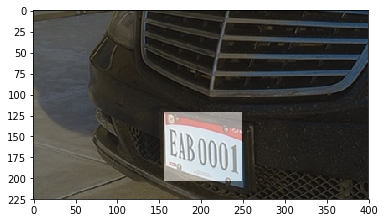

In [8]:
# Plot an image with its mask for visual inspection

plt.imshow(image)
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

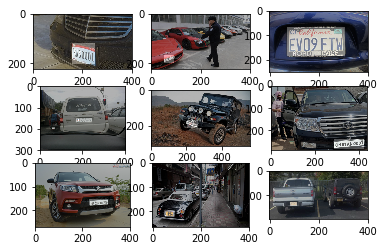

In [9]:
# Plot a range of images to ensure their masks were generated correctly

for i in range(9):
    plt.subplot(330 + 1 + i)
    image = train_set.load_image(i)
    plt.imshow(image)
    mask, _ = train_set.load_mask(i)
    for j in range(mask.shape[2]):
        plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
plt.show()

In [10]:
# Load and print the image info objects to confirm previous function calls exectuted correctly

for image_id in train_set.image_ids:
    info = train_set.image_info[image_id]
    print(info)

{'annotation': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/annotations/348.xml', 'id': '348', 'path': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/images/348.png', 'source': 'dataset'}
{'annotation': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/annotations/360.xml', 'id': '360', 'path': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/images/360.png', 'source': 'dataset'}
{'annotation': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/annotations/176.xml', 'id': '176', 'path': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/images/176.png', 'source': 'dataset'}
{'annotation': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_plates/annotations/88.xml', 'id': '88', 'path': '/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license

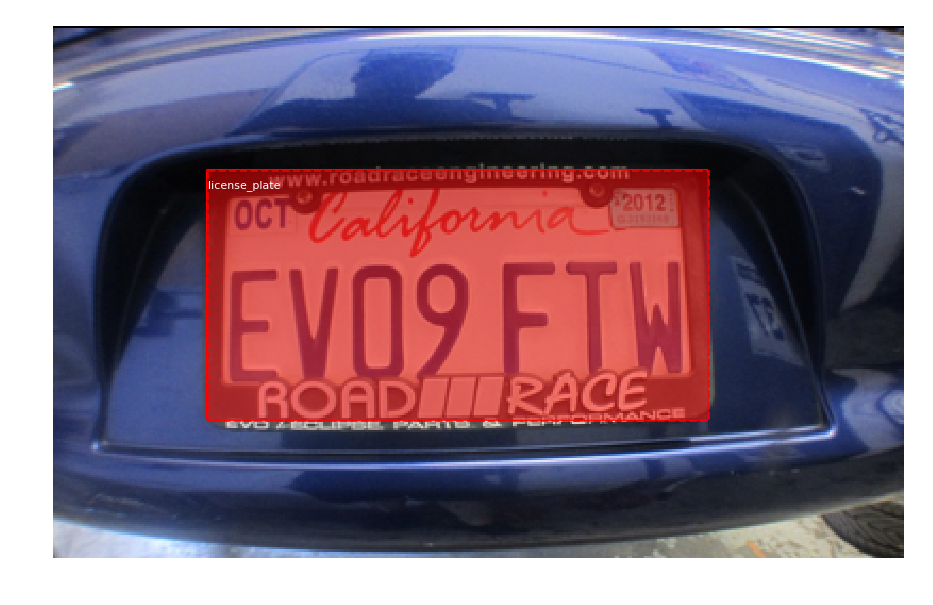

In [11]:
# Load and display an image & generate a mask with a class id using the bounding box info extracted from the mask

image_id = 2
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Modeling

In [12]:
# Define and instantiate the model configuration. Give it a name, define the number of classes, and define the number
# of steps per epoch (batch size) which is the number of images in the training set

class LicenseConfig(Config):
    NAME = "license_cfg"
    NUM_CLASSES = 1 + 1
    STEPS_PER_EPOCH = 365

In [ ]:
# Instantiate the config

config = LicenseConfig()

In [13]:
# Define the model

model = MaskRCNN(mode='training', model_dir='./', config=config)

In [17]:
# Load the weights downloaded from the mscoco dataset

model.load_weights('/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/mask_rcnn_coco.h5', 
                   by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

In [18]:
# Train the model

model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./license_cfg20211026T0011/mask_rcnn_license_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

/Users/joshblumer/opt/anaconda3/envs/mask-env/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/joshblumer/opt/anaconda3/envs/mask-env/lib/python3.5/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
365/365 [==============================] - 11569s 32s/step - loss: 1.3298 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.0331 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.4466 - val_loss: 1.2498 - val_rpn_class_loss: 0.0123 - val_rpn_bbox_loss: 0.5594 - val_mrcnn_class_loss: 0.0394 - val_mrcnn_bbox_loss: 0.3349 - val_mrcnn_mask_loss: 0.3038
Epoch 2/5
365/365 [==============================] - 11562s 32s/step - loss: 0.7213 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2704 - val_loss: 1.1792 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.4478 - val_mrcnn_class_loss: 0.0213 - val_mrcnn_bbox_loss: 0.3249 - val_mrcnn_mask_loss: 0.3807
Epoch 3/5
365/365 [==============================] - 11556s 32s/step - loss: 0.7026 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2685 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1486 - mrcnn_mask_loss: 0.2500 - val_loss: 1.2851 - val_rpn_c

# Model Evaluation

In [19]:
# Define the prediction configuration class info to be passed to the model

class PredictionConfig(Config):
    NAME = "license_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [20]:
# Define a function to calculate the mAP (meanAbsolutePrecision) for a specific dataset, given a specific model and 
# a specific configuration 

def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, convert pixel values and image into one sample, make prediction
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        # make and extract prediction, calculate statistics
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [28]:
# Prepare the model prediction configuration and evaluate the model

# Instantiate Config, define model, and load the weights
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights('/Users/joshblumer/FlatironDSM/CapstoneProject/dsc-project-template/license_models/mask_rcnn_license_cfg_0005.h5', by_name=True)

# Evaluate training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

# Evaluate test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.865
Test mAP: 0.875


## Display Predictions

In [73]:
# Define a function that take a dataset, model, and configuration to plot photos with their actual bounding bozes 
# and their predictions:

def plot_actual_vs_predicted(dataset, model, cfg, n_images=3):
    for i in range(n_images):
        # load the image and mask, convert the pixel values and image into one sample
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        plt.imshow(image)
        plt.title('Actual')
        
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
            
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        
        # plot each box
        for box in yhat['rois']:
            # get coordinates, calculate dimensions, create shape, and draw box
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
            
    # show the figure
    plt.show()

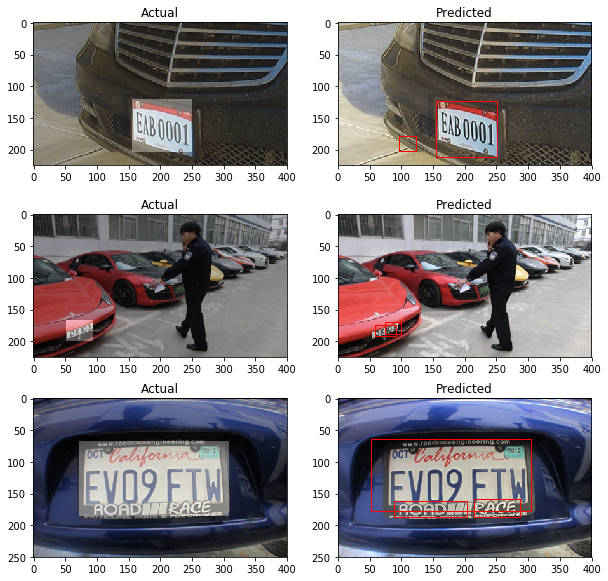

In [76]:
# Plot predictions for train dataset

plt.figure(figsize=(10,10))
plot_actual_vs_predicted(train_set, model, cfg)

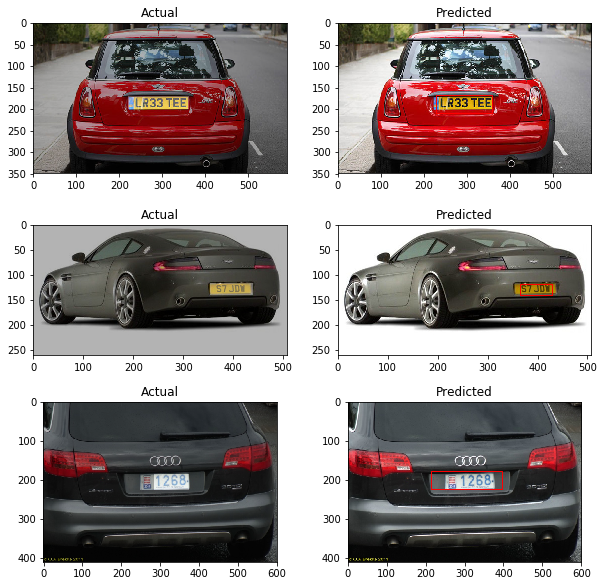

In [77]:
# Plot predictions for test dataset

plt.figure(figsize=(10,10))
plot_actual_vs_predicted(test_set, model, cfg)

# Conclusions

This is my conclusion